## **Installations & Imports**

In [782]:
!pip install pandas
!pip install yfinance
!pip install scikit-learn
!pip install projectpro
!pip install keras-tuner

In [783]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

import yfinance as yf

import keras
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import os 

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.layers import LSTM, SimpleRNN, Dense
from keras.models import Sequential
from keras.layers import Dense

from projectpro import model_snapshot, checkpoint
import pandas_ta as ta

import keras_tuner as kt

In [784]:
keras.backend.set_image_data_format("channels_last")
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
yf.pdr_override()
%matplotlib inline

## **Time Series Data**

### Retreive Data

In [785]:
now = datetime(year=2024, month=2, day=23)
start = now - relativedelta(years=10)
dataset = yf.download('NVDA', start, now)
print(dataset)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-02-24    4.650000    4.762500    4.607500    4.727500    4.460092   
2014-02-25    4.700000    4.720000    4.635000    4.685000    4.439953   
2014-02-26    4.675000    4.745000    4.662500    4.677500    4.432846   
2014-02-27    4.677500    4.725000    4.612500    4.625000    4.383091   
2014-02-28    4.600000    4.645000    4.527500    4.595000    4.354660   
...                ...         ...         ...         ...         ...   
2024-02-15  738.690002  739.750000  724.000000  726.580017  726.580017   
2024-02-16  741.000000  744.020020  725.010010  726.130005  726.130005   
2024-02-20  719.469971  719.559998  677.340027  694.520020  694.520020   
2024-02-21  680.059998  688.880005  662.479980  674.719971  674.719971   
2024-02-22  750.250000  785.750000  742.200

### Partition Training & Testing Set

In [786]:
def train_test_split(dataset, end, columns=['Close']):
    start_test = end - relativedelta(years=1)
    end_test = end

    end_train = start_test
    start_train = end_train - relativedelta(years=4)

    train = dataset.loc[start_train:end_train, columns].values
    test = dataset.loc[start_test:end_test, columns].values
    
    return train, test


In [787]:
train_set, test_set = train_test_split(dataset, now)

In [788]:
def train_test_plot(train_set, test_set):
    plt.figure(figsize=(16, 4))
    plt.plot(train_set, label=f"Train (Before {test_set[0][0]})")
    plt.plot(range(len(train_set), len(train_set) + len(test_set)), test_set, label=f"Test ({test_set[0][0]} and beyond)")
    plt.legend()
    plt.title("Stock Price")
    plt.show()

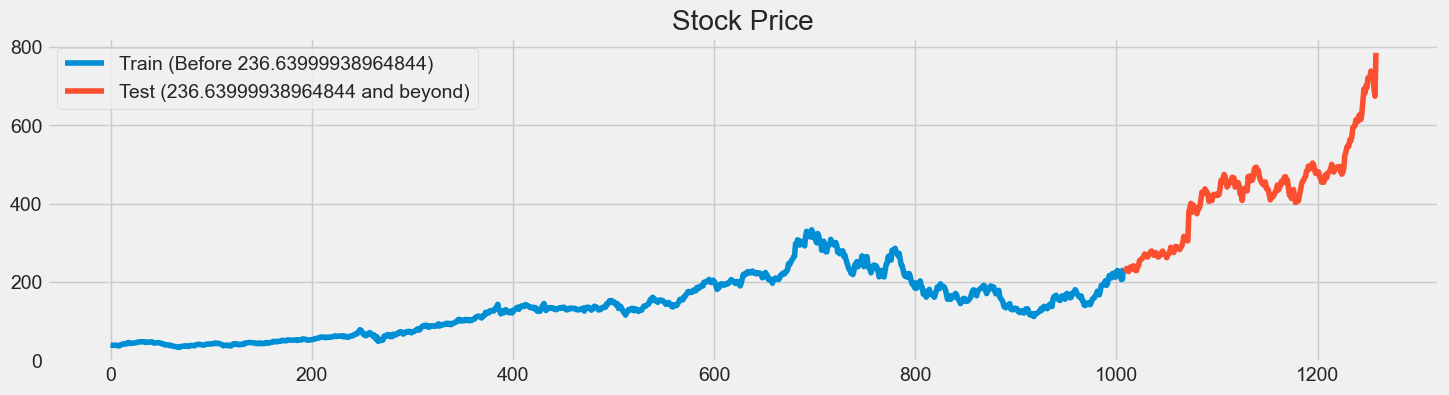

In [789]:
train_test_plot(train_set, test_set)

### Scaling Data Set 

In [790]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = train_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

### Windows

In [791]:
n_steps = 1
features = 1

In [792]:
# Split sequence of data into input-output pairs consisteing of n_seps
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [793]:
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [794]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)

### Evaluation

In [795]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
    plt.plot(test, color="gray", label="Real", linewidth=1.5)  # Make real data line gray and slightly thicker
    plt.plot(predicted, color="#1f77b4", label="Predicted", linewidth=1.5)  # Change predicted line color and make it thinner
    plt.title(f'{title}', fontsize=14)  # Adjust title font size
    plt.xlabel("Time", fontsize=12)  # Adjust X label font size
    plt.ylabel(f'{title}', fontsize=12)  # Adjust Y label font size
    plt.legend(fontsize=10)  # Adjust legend font size
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add gridlines for better readability
    plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
    plt.show()

In [796]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(y_true, y_pred):
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate R-squared (R2) Score
    r2 = r2_score(y_true, y_pred)

    # Print the results
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-squared (R2) Score: {r2:.2f}")

## **RNN**

### Set Up

In [797]:
def plot_loss(history):
    plt.figure(figsize=(15,10))
    
    # Adjusting line color to green and making it thinner using 'linewidth'
    plt.plot(history.history['loss'], label='loss', color='green', linewidth=2)
    
    # Enhancing plot appearance
    plt.legend(loc='best')
    plt.title('Model Loss Over Epochs')  # Adding a title for clarity
    plt.xlabel('Epochs')  # Labeling the x-axis
    plt.ylabel('Loss')  # Labeling the y-axis
    plt.grid(True)  # Adding a grid for better readability
    plt.tight_layout()  # Adjusting subplots to fit into the figure area
    
    plt.show()

In [798]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=125, input_shape=(n_steps, features)))
model_rnn.add(Dense(units=1))

In [799]:
# Compiling the model
model_rnn.compile(optimizer="RMSprop", loss="mse")

In [800]:
history = model_rnn.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
model_snapshot("34db30")

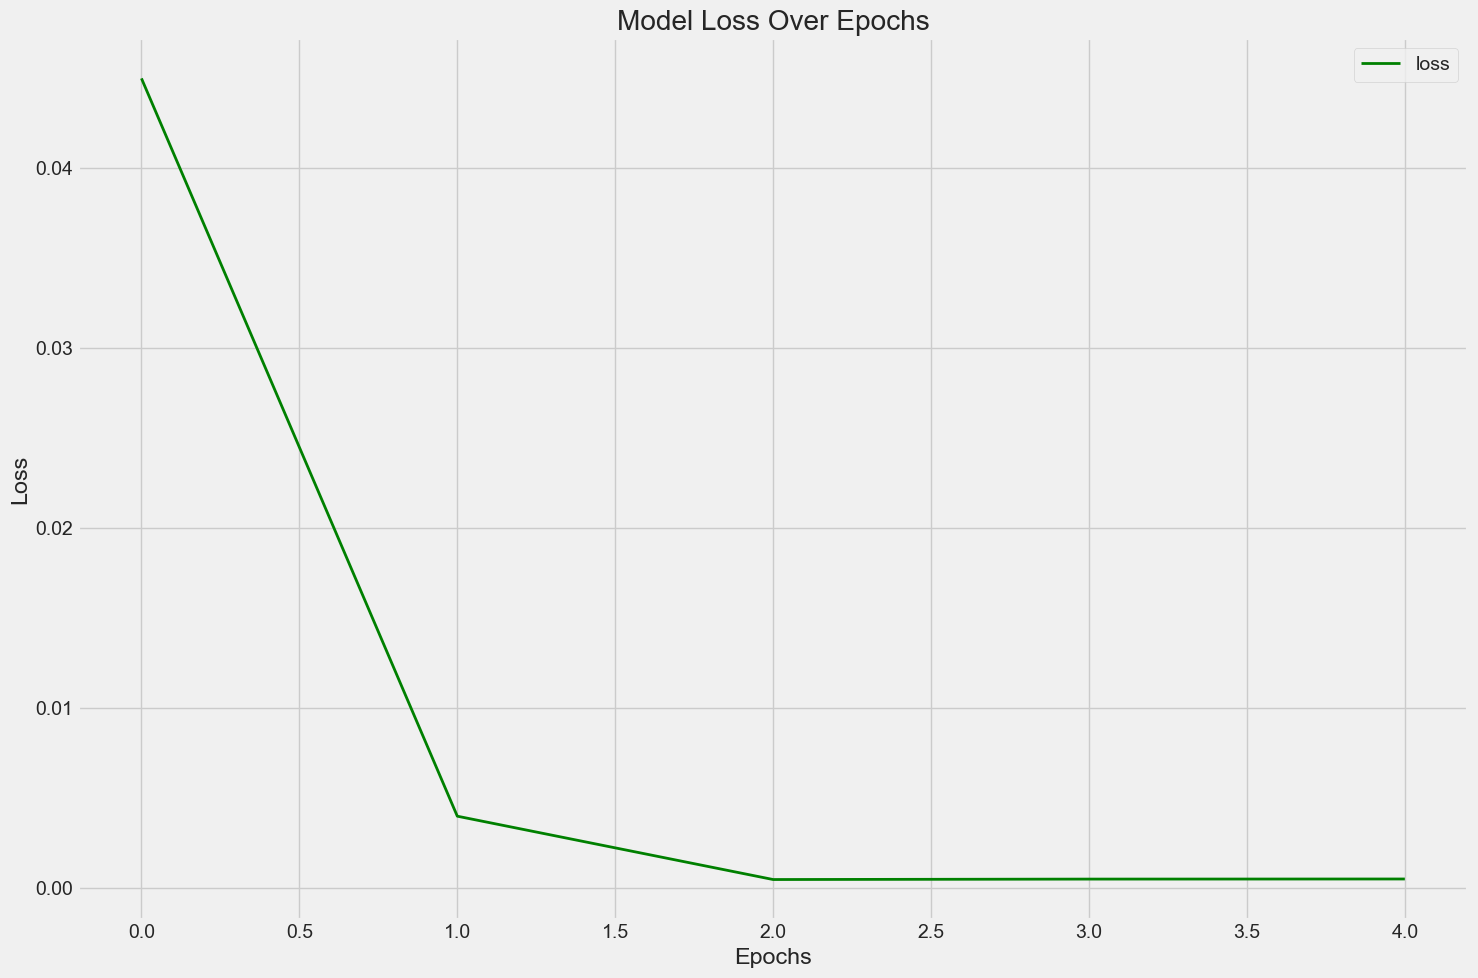

In [801]:
plot_loss(history)

### Prediction

In [802]:
# Scaling
inputs = sc.transform(test_set.reshape(-1, 1))

In [803]:
# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(-1, n_steps, features)

In [804]:
# Prediction
predicted_stock_price = model_rnn.predict(X_test)
# Inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 [==============================] - 0s 756us/step


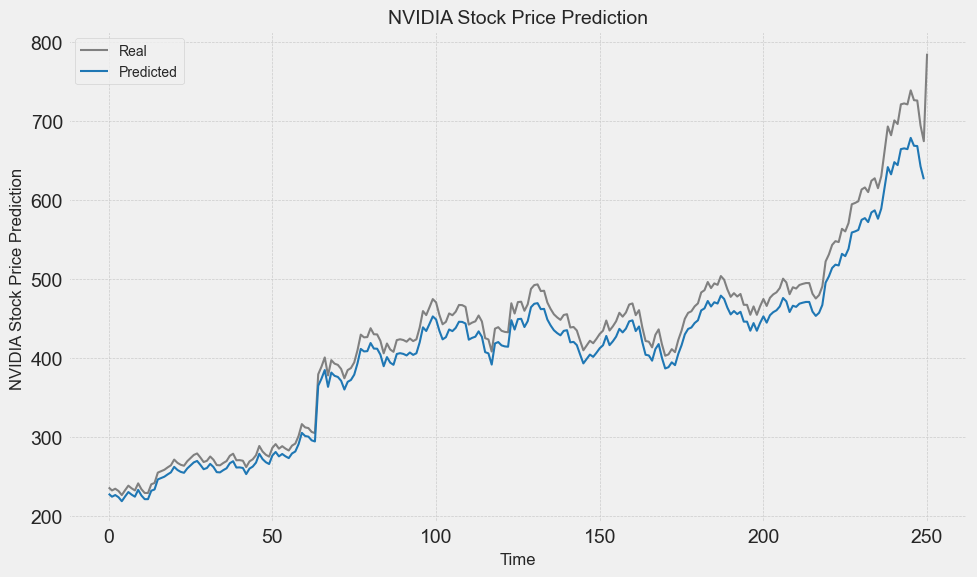

In [805]:
plot_predictions(test_set, predicted_stock_price, "NVIDIA Stock Price Prediction")

In [806]:
evaluate_model(y_test, predicted_stock_price)

Mean Squared Error (MSE): 174413.65
Root Mean Squared Error (RMSE): 417.63
Mean Absolute Error (MAE): 404.14
R-squared (R2) Score: -1144373.12


### Sequence Generation

In [807]:
steps_in_future = 7

In [808]:
def sequence_generation(dataset: pd.DataFrame, sc: MinMaxScaler, model:Sequential, steps_future: int):
    high_dataset = dataset.iloc[len(dataset) - len(test_set) - n_steps:]["High"]
    high_dataset = sc.transform(high_dataset.values.reshape(-1, 1))
    inputs = high_dataset[:n_steps]

    for _ in range(steps_future):
        curr_pred = model.predict(inputs[-n_steps:].reshape(-1, n_steps, features), verbose=0)
        inputs = np.append(inputs, curr_pred, axis=0)

    return sc.inverse_transform(inputs[n_steps:])

In [809]:
results = sequence_generation(dataset, sc, model_rnn, steps_in_future)

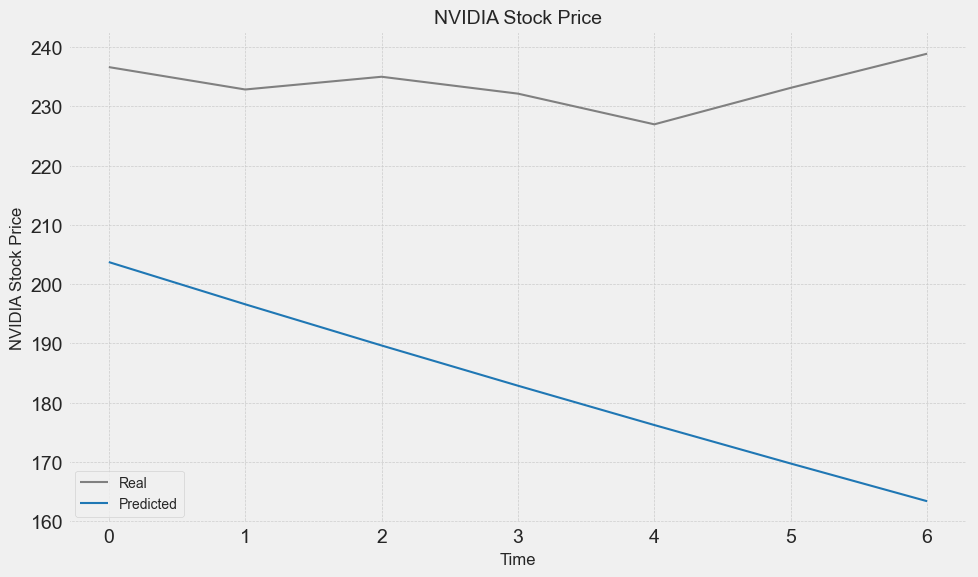

In [810]:
plot_predictions(test_set[:steps_in_future], results, "NVIDIA Stock Price")

## **LSTM**

In [811]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))

In [812]:
# model_lstm = Sequential()
# model_lstm.add(LSTM(units=128, input_shape=(n_steps, features), return_sequences=True))
# model_lstm.add(LSTM(units=64, return_sequences=True))  # Add another LSTM layer
# model_lstm.add(LSTM(units=32))  # Add one more LSTM layer
# model_lstm.add(Dense(units=1))

In [813]:
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

In [814]:
history = model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

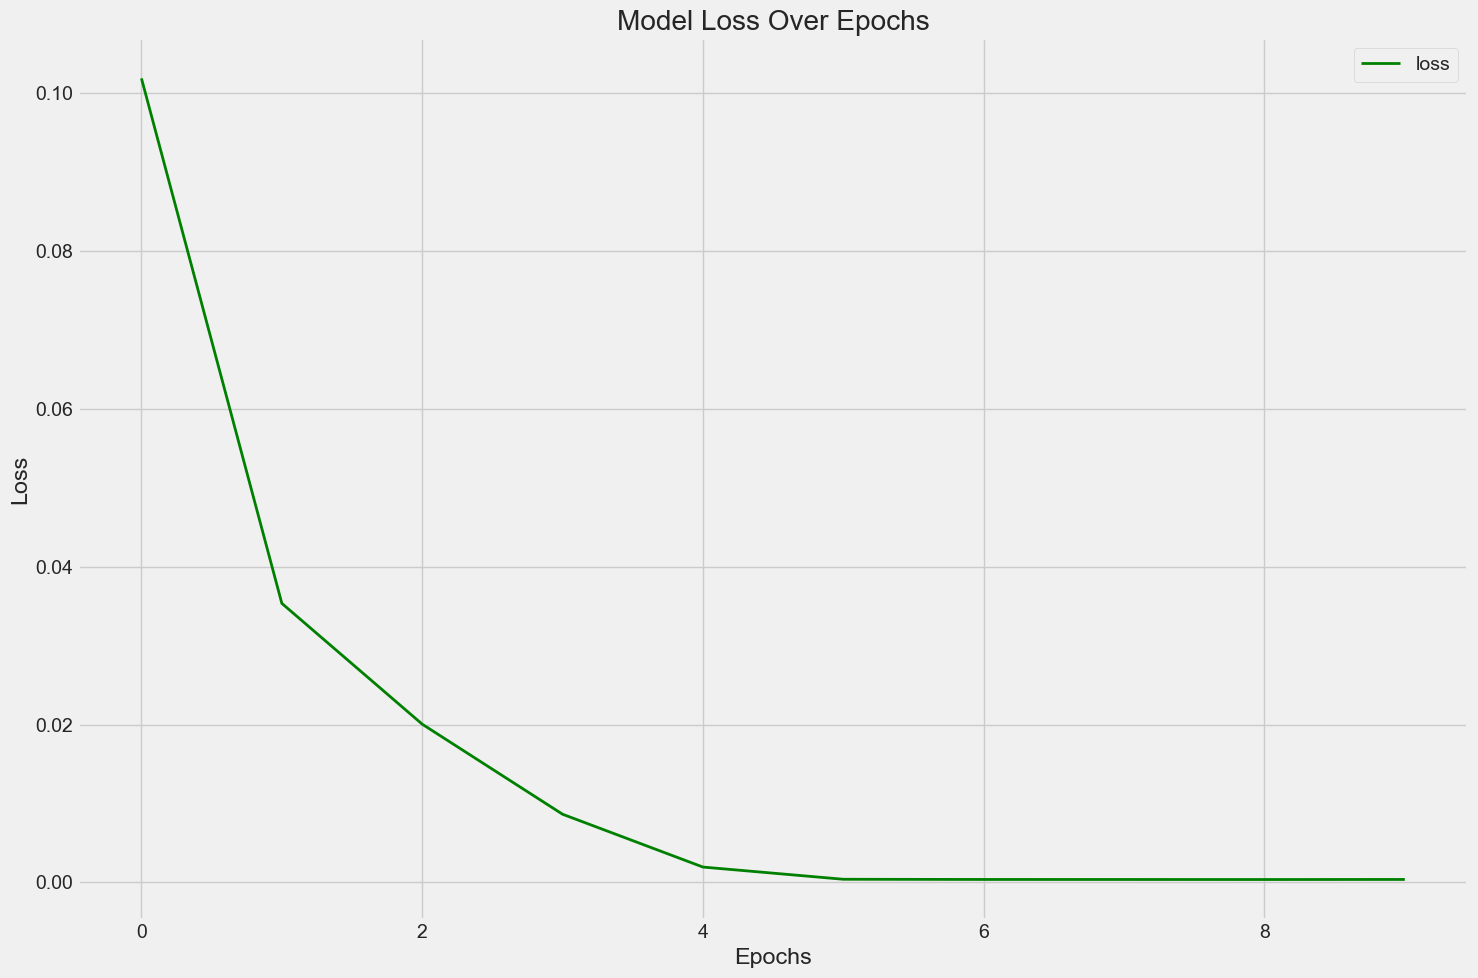

In [815]:
plot_loss(history)

### Prediction

In [816]:
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 [==============================] - 0s 1ms/step


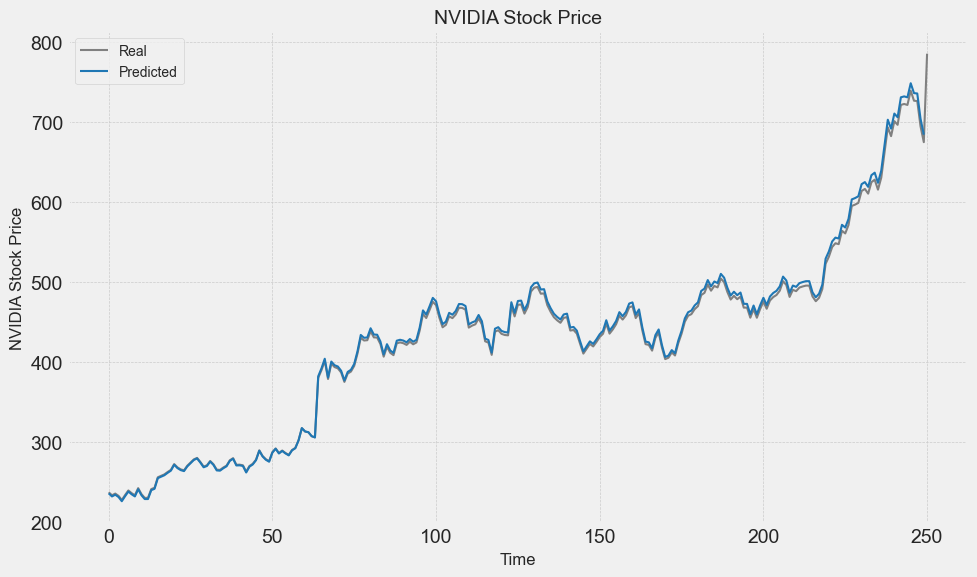

In [817]:
plot_predictions(test_set, predicted_stock_price, "NVIDIA Stock Price")

In [818]:
evaluate_model(y_test, predicted_stock_price)

Mean Squared Error (MSE): 196607.07
Root Mean Squared Error (RMSE): 443.40
Mean Absolute Error (MAE): 427.35
R-squared (R2) Score: -1289990.00


### Sequence Generation

In [819]:
results = sequence_generation(dataset, sc, model_lstm, steps_in_future)

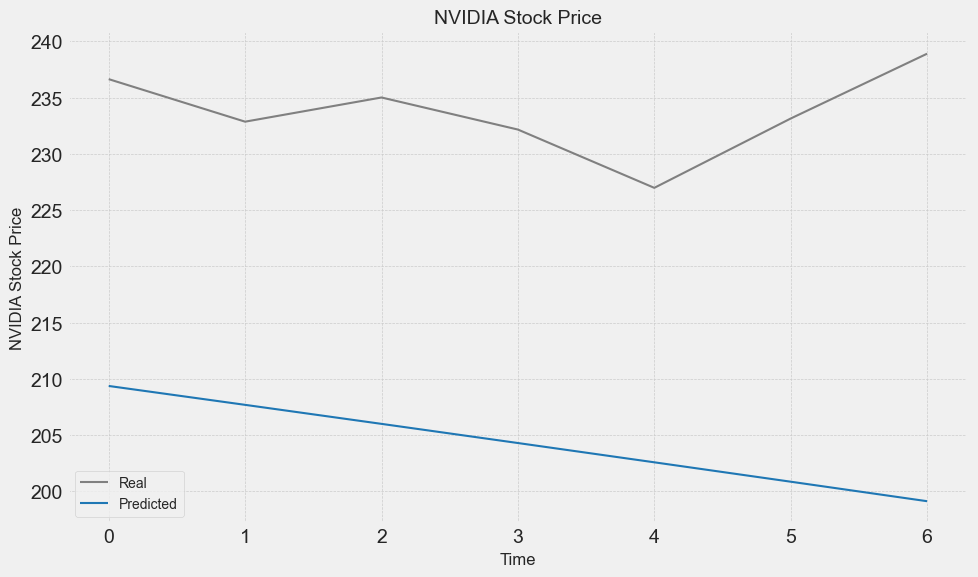

In [820]:
plot_predictions(test_set[:steps_in_future], results, "NVIDIA Stock Price")

## **Multiple Input LSTM**

In [821]:
mv_features = 6

In [822]:
multi_variate_df = yf.download('NVDA', start, now)

[*********************100%***********************]  1 of 1 completed


### Other Indicators

In [823]:
multi_variate_df['RSI'] = ta.rsi(multi_variate_df.Close, length=15)
multi_variate_df['EMAF'] = ta.ema(multi_variate_df.Close, length=20)
multi_variate_df['EMAM'] = ta.ema(multi_variate_df.Close, length=100)
multi_variate_df['EMAS'] = ta.ema(multi_variate_df.Close, length=150)

In [824]:
multi_variate_df['Target'] = multi_variate_df['Adj Close'] - dataset.Open
multi_variate_df['Target'] = multi_variate_df['Target'].shift(-1)
multi_variate_df.dropna(inplace=True)
multi_variate_df.drop(['Volume', 'Close'], axis=1, inplace=True)

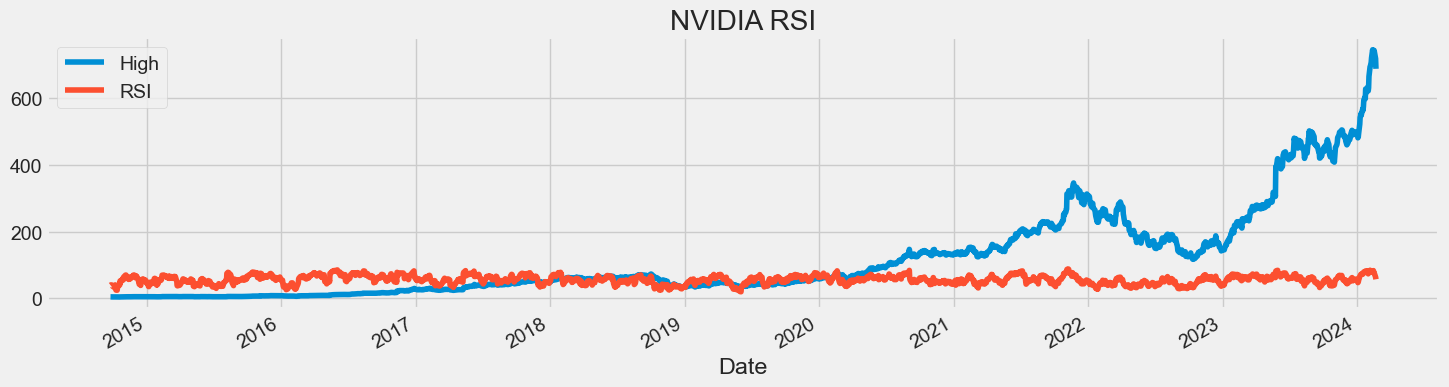

In [825]:
multi_variate_df.loc[f"{start}":f"{now}", ['High', 'RSI']].plot(figsize=(16, 4), legend=True)
plt.title("NVIDIA RSI")
plt.show()

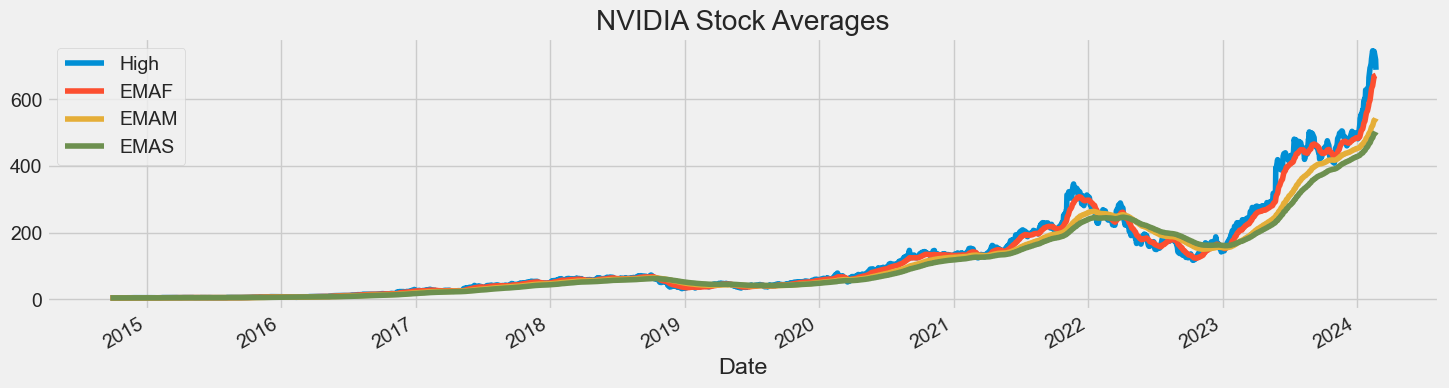

In [826]:
multi_variate_df.loc[f"{start}":f"{now}", ['High', 'EMAF', 'EMAM', 'EMAS']].plot(figsize=(16, 4), legend=True)
plt.title("NVIDIA Stock Averages")
plt.show()

In [827]:
feat_columns = ['Open', 'High', 'RSI', 'EMAF', 'EMAM', 'EMAS']
label_col = ['Target']

### Partitioning Data

In [828]:
mv_training_set, mv_test_set = train_test_split(multi_variate_df, now, feat_columns + label_col)

In [829]:
X_train = mv_training_set[:, :-1]
y_train = mv_training_set[:, -1]

X_test = mv_test_set[:, :-1]
y_test = mv_test_set[:, -1]

### Scaling Data

In [830]:
mv_sc = MinMaxScaler(feature_range=(0, 1))
X_train = mv_sc.fit_transform(X_train).reshape(-1, 1, mv_features)
X_test = mv_sc.transform(X_test).reshape(-1, 1, mv_features)

### Model

In [831]:
model_mv = Sequential()
model_mv.add(LSTM(units=125, input_shape=(1, mv_features)))
model_mv.add(Dense(units=1))
# Compiling the model
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
model_mv.compile(optimizer=optimizer, loss="mse")
# model_mv.compile(optimizer="RMSprop", loss="mse")

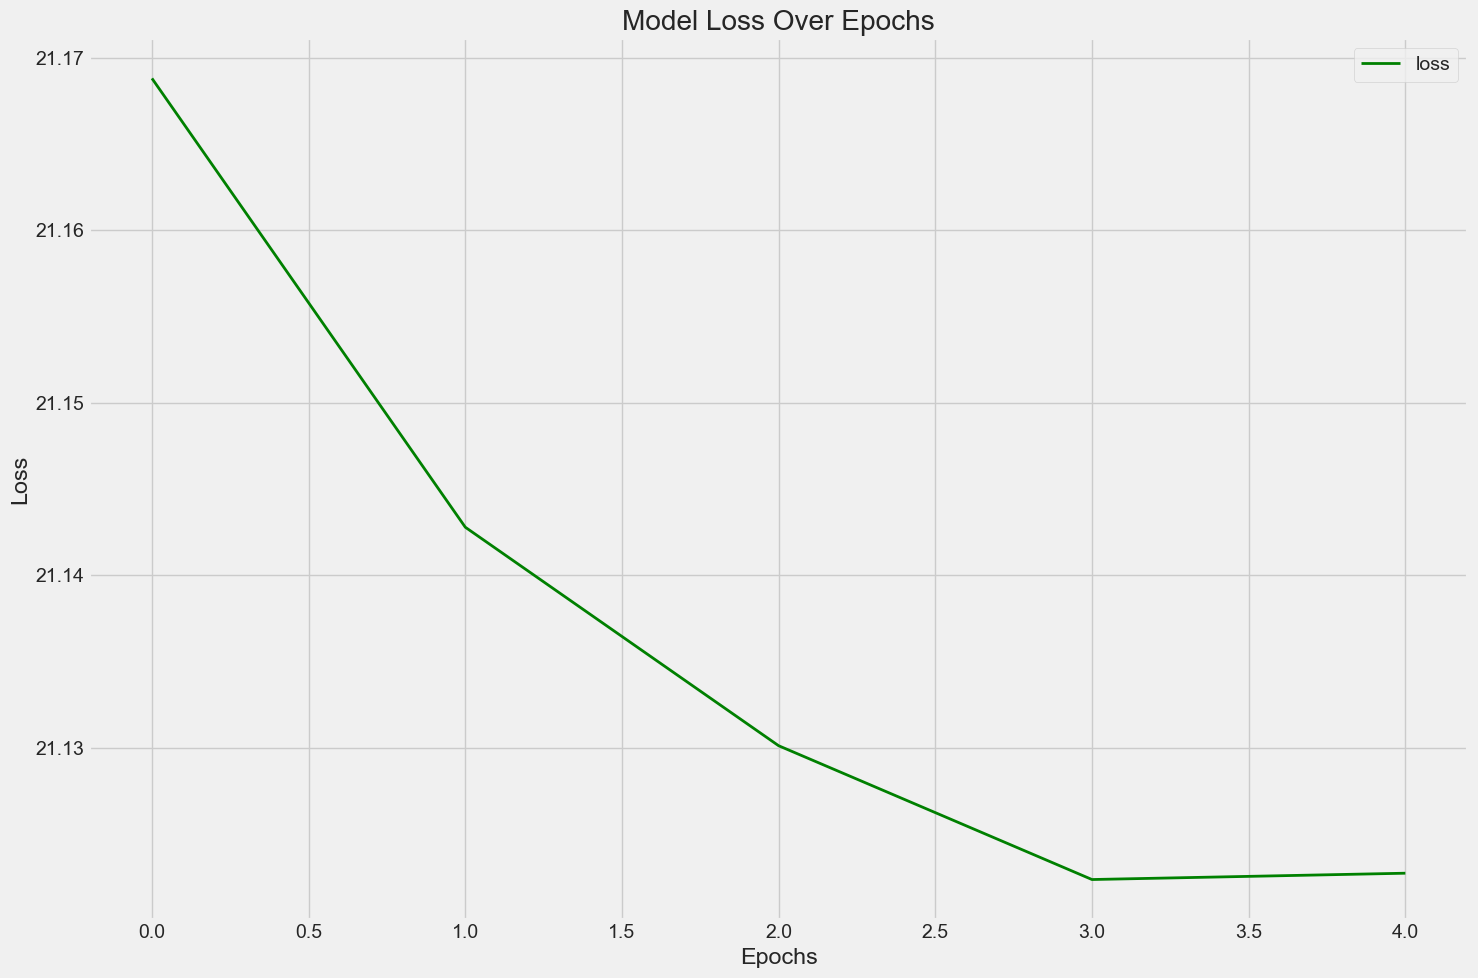

In [832]:
history = model_mv.fit(X_train, y_train, epochs=5, batch_size=64, verbose=0)
model_snapshot("34db30")
plot_loss(history)

In [833]:
# predictions = model_mv.predict(X_test)
# plot_predictions(y_test, predictions, "NVIDIA Stock Price")

8/8 [==============================] - 0s 1ms/step


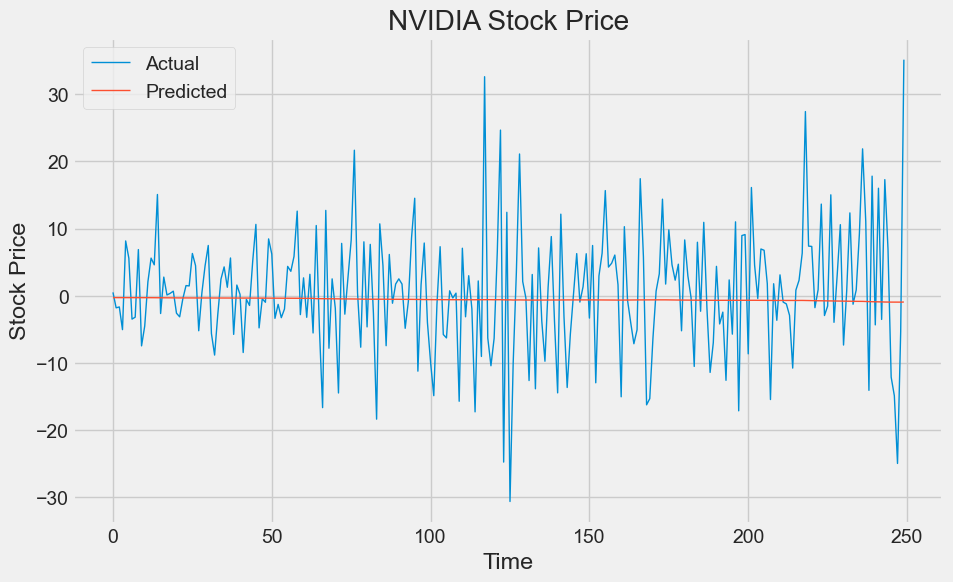

In [834]:
predictions = model_mv.predict(X_test)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', linewidth=1)  # Adjust linewidth here
plt.plot(predictions, label='Predicted', linewidth=1)  # Adjust linewidth here
plt.title("NVIDIA Stock Price")
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [835]:
evaluate_model(y_test, predictions)

Mean Squared Error (MSE): 86.34
Root Mean Squared Error (RMSE): 9.29
Mean Absolute Error (MAE): 6.94
R-squared (R2) Score: -0.02


In [836]:
import shutil

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=500, step=50), 
                   input_shape=(1, mv_features), 
                   return_sequences=hp.Boolean('return_sequences')))
    if hp.Boolean('additional_lstm_layer'):
        model.add(LSTM(units=hp.Int('units', min_value=50, max_value=500, step=50), 
                       return_sequences=False))
    model.add(Dense(units=1))
    
    # You can also tune the learning rate
    optimizer = keras.optimizers.RMSprop(learning_rate=hp.Choice('learning_rate', [0.01, 0.001, 0.0001]))
    model.compile(optimizer=optimizer, loss="mse")
    
    return model

shutil.rmtree('my_dir/lstm_tuning', ignore_errors=True)
# Define the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',  # You can also use 'val_mean_squared_error' here
    max_trials=5,  # Number of trials to run
    executions_per_trial=3,  # Number of models to train for each trial
    directory='my_dir',  # Directory to save logs and models
    project_name='lstm_tuning'
)

# Display search space overview
tuner.search_space_summary()

# Perform the hyperparameter search
tuner.search(
    X_train, 
    y_train, 
    epochs=5,
    batch_size=64,
    validation_data=(X_test, y_test)
)

# Get the top-performing model configurations
models = tuner.get_best_models(num_models=2)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 5 Complete [00h 00m 00s]

Best val_loss So Far: 85.18168640136719
Total elapsed time: 00h 00m 34s


8/8 [==============================] - 0s 1ms/step
Mean Squared Error (MSE): 85.18
Root Mean Squared Error (RMSE): 9.23
Mean Absolute Error (MAE): 6.89
R-squared (R2) Score: -0.01


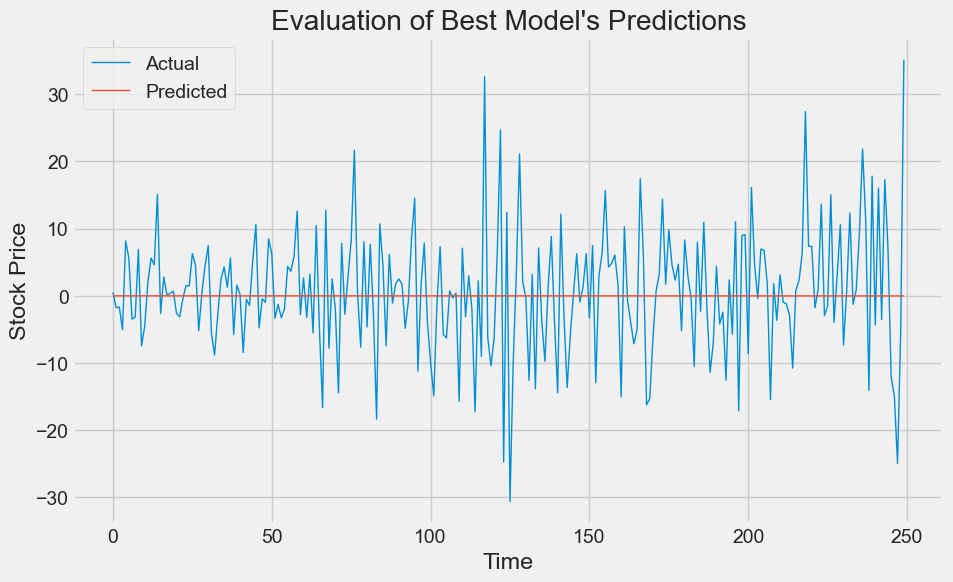

In [840]:
# Assuming 'models' contains the top-performing models from the tuning process
best_model = models[0]

# 1. Make Predictions on the Test Set
# Note: Ensure your test data (X_test) is prepared similarly to how it was for training
predictions = best_model.predict(X_test)

# Since we've used MinMaxScaler, if your target variable was scaled, you may need to inverse transform 
# predictions and actual values before evaluation and plotting
# predictions = sc.inverse_transform(predictions)

# 2. Evaluate the Model
# If necessary, adjust the function or the inputs to match how you've processed your target variable
evaluate_model(y_test, predictions)

# 3. Plot Predictions Against Actual Values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', linewidth=1)
plt.plot(predictions.flatten(), label='Predicted', linewidth=1)  # Ensure predictions are properly shaped
plt.title("Evaluation of Best Model's Predictions")
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()
